In [26]:
import json
import pickle as pkl
import re
from nltk.translate import bleu_score
from tqdm import tqdm
import jiwer
from matplotlib import pyplot as plt

#### Load Open Subtitle Dataset

In [2]:
# Load Open Subtitle
with open('en_subtitles.pkl', 'rb') as f:
    en_subtitle = pkl.load(f)
with open('zh_subtitles.pkl', 'rb') as f:
    zh_subtitle = pkl.load(f)

In [3]:
clean_en_subtitle = []

pattern = r'\.|\,|\?|\!|\;'
for x in tqdm(en_subtitle):
    temp = " ".join(re.split(pattern, x.strip(' ,.-!')))
    clean_en_subtitle.append([
        x,
        temp
    ])

100%|██████████| 9969005/9969005 [00:20<00:00, 482401.04it/s]


In [155]:
with open('cleaned_en_subtitle.pkl', 'wb') as f:
    pkl.dump(clean_en_subtitle, f)

In [152]:
for x in clean_en_subtitle:
    print(x)

['Ah, this is greasy. I want to eat kimchee.', 'Ah  this is greasy  I want to eat kimchee']
["Is Chae Yoon's coordinator in here?", "Is Chae Yoon's coordinator in here "]
["Excuse me, aren't you Chae Yoon's coordinator?", "Excuse me  aren't you Chae Yoon's coordinator "]
['Yes. Me?', 'Yes  Me ']
['-Chae Yoon is done singing.', 'Chae Yoon is done singing']
['This lady right next to me... everyone knows who she is right?', 'This lady right next to me    everyone knows who she is right ']
['She is my forever idol...she is my rival whom I can never win against, she is the one who always makes me happy, and she is my mother.', 'She is my forever idol   she is my rival whom I can never win against  she is the one who always makes me happy  and she is my mother']
['Everyone should remember my mom as one of the greatest movie stars, but instead of becoming an actress, she wanted to become a singer just like me.', 'Everyone should remember my mom as one of the greatest movie stars  but instead 

#### Load Memor Dataset and turn into utterances

In [46]:
# Load Memor Dataset
with open('memor/data.json') as f:
    data = json.load(f)
utterances = []
for item in data:
    if item.strip().split('_')[0]=='S01E01':
        utterances.extend(data[item]['sentences'])

### Process data from alignment

In [72]:
# Set Transformation
ground_truth = "if it's observed after it's left the plane but before it hits its target"
hypothesis = "If it's observed after it left the plane, before it hits its target..."

transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemovePunctuation(),
    jiwer.Strip()
])

print(transformation(ground_truth))
print(transformation(hypothesis))

if it is observed after it is left the plane but before it hits its target
if it is observed after it left the plane before it hits its target


In [75]:
# Process Episodes
segments = []
pattern = r'\.|\,|\?|\!|\;'
for utt in utterances:
    temp = re.split(pattern, utt.strip(' ,.-!'))
    for item in temp:
        item = transformation(item)
        if item!="":
            segments.append(item)

In [76]:
# Process Subtitle Subset
base = 4424331
bias = 400

subtitles = []
for item in en_subtitle[base-bias: base+bias]:
    item = transformation(item)
    if item!="":
        subtitles.append(item)

In [99]:
# Get Bi-Subtitle Subset
base = 4424331
bias = 400

bi_subtitles = []
for i in range(len(en_subtitle[base-bias: base+bias])-1):
    item = transformation(en_subtitle[i]) + " " + transformation(en_subtitle[i+1])
    if item!="":
        bi_subtitles.append(item)

In [100]:
for x in bi_subtitles:
    print(x)

ah this is greasy i want to eat kimchee is chae yoon is coordinator in here
is chae yoon is coordinator in here excuse me are not you chae yoon is coordinator
excuse me are not you chae yoon is coordinator yes me
yes me chae yoon is done singing
chae yoon is done singing this lady right next to me everyone knows who she is right
this lady right next to me everyone knows who she is right she is my forever idolshe is my rival whom i can never win against she is the one who always makes me happy and she is my mother
she is my forever idolshe is my rival whom i can never win against she is the one who always makes me happy and she is my mother everyone should remember my mom as one of the greatest movie stars but instead of becoming an actress she wanted to become a singer just like me
everyone should remember my mom as one of the greatest movie stars but instead of becoming an actress she wanted to become a singer just like me when i was stressed and exhausted she would always sing me a s

In [101]:
def get_optimal_wer(ground_truth, hypothesis_pool):
    scores = []
    for i, hypothesis in enumerate(hypothesis_pool):
        scores.append(jiwer.compute_measures(ground_truth, hypothesis)['wer'])
    return min(scores), hypothesis_pool[scores.index(min(scores))], utt, scores.index(min(scores))

In [104]:
base = 4424331
bias = 400
# Gather subtitle and episodes for the same episoide portion
indexs = []
count = 0
for utt in segments:
    result = get_optimal_wer(utt, subtitles)
    if 0<result[0]<1:
        indexs.append(result[-1])
        for item in result:
            count += 1
            print(item)
        print('=='*50)
print(count)

0.08
if a photon is directed through a plane with two slits in it and either is observed it will not go through both
if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits
397
0.3333333333333333
if unobserved it will
if it is unobserved it will
398
0.125
if it is observed after it left the plane before it hits its target
if it is observed after it is left the plane but before it hits its target
399
0.25
agreed what is your point
what is your point
401
0.75
is this agreed
there is no point
7
0.36363636363636365
there is no point i just think it is a good idea for a tshirt
i just think it is a good idea for a tshirt
402
0.5
twentysix across is mcm
one across is aegean
404
0.75
eemeli what is it
eight down is nabakov
47
0.6666666666666666
nobody is
fourteen down is
61
0.6666666666666666
quit your yapping
move your finger
3
0.4
phylum which makes 14 across portauprince
which makes fourteen across portauprince
406
0.8
is th

In [91]:
print(indexs)

[397, 399, 400, 404, 408, 578, 419, 421, 423, 426, 427, 428, 427, 428, 361, 430, 637, 432, 440, 578, 442, 443, 444, 448, 449, 452, 452, 452, 452, 296, 737, 361, 485, 8, 487, 495, 496, 501, 503, 505, 507, 515, 361, 516, 8, 524, 526, 8, 531, 532, 495, 637, 361, 361, 539, 495, 361, 548, 637, 552, 361, 554, 555, 559, 135, 561, 578, 563, 566, 579, 591, 592, 8, 593, 595, 578, 615, 616, 621, 452, 625, 626, 625, 626, 627, 628, 630, 631, 637, 639, 637, 649, 650, 651, 652, 653, 658, 8, 660, 665, 666, 667, 668, 676, 677, 690, 703, 495, 720, 722, 723, 724, 722, 723, 724, 725, 726, 361, 728, 729, 578, 637, 737]


#### Gather Data from the same episode

In [21]:
base = 4424331
bias = 400

# Ground Truth and Hypothesis
# ground_truth = utterances[11]
ground_truth = 'if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits.'
hypothesis = en_subtitle[base]

# Calculate measures
measures = jiwer.compute_measures(ground_truth, hypothesis)
print(measures)
print(ground_truth)
print(hypothesis)

{'wer': 0.84, 'mer': 0.8076923076923077, 'wil': 0.8888888888888888, 'wip': 0.11111111111111112, 'hits': 5, 'substitutions': 3, 'deletions': 17, 'insertions': 1}
if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits.
- ...it will not have gone through both slits.


In [33]:
scores = []
for hypothesis in en_subtitle[base-bias: base+bias]:
    score = jiwer.compute_measures(ground_truth, hypothesis)
    print(score)
    print(hypothesis)
    wer = score['wer']
    if wer<0.8:
        scores.append(wer)
    print('=='*50)

{'wer': 1.0, 'mer': 1.0, 'wil': 1.0, 'wip': 0.0, 'hits': 0, 'substitutions': 7, 'deletions': 18, 'insertions': 0}
I think that we can manage that.
{'wer': 0.96, 'mer': 0.96, 'wil': 0.9955555555555555, 'wip': 0.0044444444444444444, 'hits': 1, 'substitutions': 8, 'deletions': 16, 'insertions': 0}
I'm not going to take part in that nonsense.
{'wer': 0.96, 'mer': 0.96, 'wil': 0.996, 'wip': 0.004, 'hits': 1, 'substitutions': 9, 'deletions': 15, 'insertions': 0}
You don't live here, Iisakki. It's not of your concern.
{'wer': 1.0, 'mer': 1.0, 'wil': 1.0, 'wip': 0.0, 'hits': 0, 'substitutions': 3, 'deletions': 22, 'insertions': 0}
Quit your yapping.
{'wer': 1.0, 'mer': 1.0, 'wil': 1.0, 'wip': 0.0, 'hits': 0, 'substitutions': 6, 'deletions': 19, 'insertions': 0}
We'll all take care of Nikolas.
{'wer': 0.96, 'mer': 0.96, 'wil': 0.99, 'wip': 0.01, 'hits': 1, 'substitutions': 3, 'deletions': 21, 'insertions': 0}
Beginning with the Hannuses.
{'wer': 1.0, 'mer': 1.0, 'wil': 1.0, 'wip': 0.0, 'hits': 

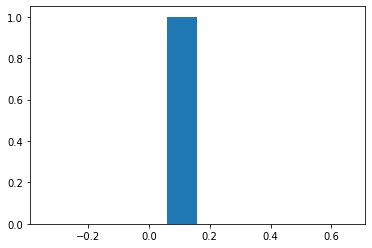

0.16
[0.16]


In [35]:
# scores.remove(1.0)
plt.hist(scores)
plt.show()
print(min(scores))
print(scores)

In [11]:
base = 4424331
bias = 400
for sub in en_subtitle[base-bias: base+bias]:
    print(sub)

I think that we can manage that.
I'm not going to take part in that nonsense.
You don't live here, Iisakki. It's not of your concern.
Quit your yapping.
We'll all take care of Nikolas.
Beginning with the Hannuses.
The boy will move to the next family on Christmas.
Is this agreed?
-Yes.
Merry Christmas, sister Aada.
I could not forget my mother and my father - and my sister Aada.
I knew they would not be coming back - but I missed them dearly.
But time heals the wounds - and by autumn the sadness began to fade away.
My boat's broken. Fix it.
-Ask your father.
My father has gone fishing.
-Ask your mother, then.
Mother can't do it.
-Give it to me.
Turn, boat!
-It won't turn!
Why doesn't it come here? Turn right!
There it goes!
I didn't know it back then - but Eemeli would become a good friend.
Good throw. It bounced off the water.
I found a great stone.
-Stretch your arm back and throw.
You can do it. One, two, three!
Let's get another one.
Then came the moment I had been dreading.
I had 

In [5]:
base = 4424331
bias = 400

pattern = r'\.|\,|\?|\!|\;'
subtitles = []
subtitles_zh = []
for i, x in enumerate(en_subtitle[base-bias: base+bias]):
    zh_source = zh_subtitle[base-bias: base+bias]
    temp = x.strip(' ,.-!')
    print(x, zh_source[i])
    for item in re.split(pattern, temp):
        if item!='':
            subtitles.append(item.strip().lower())
            subtitles_zh.append(zh_source[i])

for i in range(10):
    print(en_subtitle[i], zh_subtitle[i])

# zh_sub_pool = []
# sub_pool = []
# for i in range(len(subtitles)-1):
#     sub_pool.append(subtitles[i].strip().split(' '))
#     zh_sub_pool.append(subtitles_zh[i])
#     temp = subtitles[i] + " " + subtitles[i+1]
#     sub_pool.append(temp.strip().split(' '))
#     zh_sub_pool.append(subtitles_zh[i] + " " + subtitles_zh[i+1])
# sub_pool.append(subtitles[-1].strip().split(' '))
# zh_sub_pool.append(subtitles_zh[-1])

# zh_sub_pool = []
# sub_pool = []
# for i in range(len(subtitles)):
#     sub_pool.append(subtitles[i].strip().split(' '))
#     zh_sub_pool.append(subtitles_zh[i])

I think that we can manage that. 我觉得我们可以这么做
I'm not going to take part in that nonsense. 我不会负责这混账事
You don't live here, Iisakki. It's not of your concern. 你没住在这 丽萨奇 这事跟你无关
Quit your yapping. 你别叫了
We'll all take care of Nikolas. 我们都会照顾尼古拉斯的
Beginning with the Hannuses. 从汉纳塞思开始
The boy will move to the next family on Christmas. 圣诞节这孩子就去下一家
Is this agreed? -同意吗
-Yes. -同意
Merry Christmas, sister Aada. 圣诞快乐 亚达妹妹
I could not forget my mother and my father - and my sister Aada. 我无法忘记我的父母 和我的妹妹亚达
I knew they would not be coming back - but I missed them dearly. 我知道他们会回来的 而且我深切思念他们
But time heals the wounds - and by autumn the sadness began to fade away. 但时间会抚慰伤口 到了秋季悲伤就开始消散
My boat's broken. Fix it. -我的船破了 你能修好吗
-Ask your father. -叫你父亲
My father has gone fishing. -我父亲出去打渔了
-Ask your mother, then. -那就叫你妈妈
Mother can't do it. -妈妈不会
-Give it to me. -那给我吧
Turn, boat! -把船转向
-It won't turn! -不会转向的
Why doesn't it come here? Turn right! 为什么不能 右转
There it goes! 好了
I didn't know it back then - but Eemeli

In [188]:
for i in range(len(sub_pool)):
    print(sub_pool[i], zh_sub_pool[i])

['i', 'think', 'that', 'we', 'can', 'manage', 'that'] 我觉得我们可以这么做
["i'm", 'not', 'going', 'to', 'take', 'part', 'in', 'that', 'nonsense'] 我不会负责这混账事
['you', "don't", 'live', 'here'] 你没住在这 丽萨奇 这事跟你无关
['iisakki'] 你没住在这 丽萨奇 这事跟你无关
["it's", 'not', 'of', 'your', 'concern'] 你没住在这 丽萨奇 这事跟你无关
['quit', 'your', 'yapping'] 你别叫了
["we'll", 'all', 'take', 'care', 'of', 'nikolas'] 我们都会照顾尼古拉斯的
['beginning', 'with', 'the', 'hannuses'] 从汉纳塞思开始
['the', 'boy', 'will', 'move', 'to', 'the', 'next', 'family', 'on', 'christmas'] 圣诞节这孩子就去下一家
['is', 'this', 'agreed'] -同意吗
['yes'] -同意
['merry', 'christmas'] 圣诞快乐 亚达妹妹
['sister', 'aada'] 圣诞快乐 亚达妹妹
['i', 'could', 'not', 'forget', 'my', 'mother', 'and', 'my', 'father', '-', 'and', 'my', 'sister', 'aada'] 我无法忘记我的父母 和我的妹妹亚达
['i', 'knew', 'they', 'would', 'not', 'be', 'coming', 'back', '-', 'but', 'i', 'missed', 'them', 'dearly'] 我知道他们会回来的 而且我深切思念他们
['but', 'time', 'heals', 'the', 'wounds', '-', 'and', 'by', 'autumn', 'the', 'sadness', 'began', 'to', 'fade', 'away'] 但时间会

In [189]:
# Load TBBT Dataset
episode = []
pattern = r'\.|\,|\?|\!|\;'
for x in utterances:
    for item in re.split(pattern, x):
        if item != "":
            episode.append(item.strip().lower())
# epi_pool = []
# for i in range(len(episode)-1):
#     epi_pool.append(episode[i].strip().split(' '))
#     temp = episode[i] + " " + episode[i+1]
#     epi_pool.append(temp.strip().split(' '))
# epi_pool.append(episode[-1].strip().split(' '))

epi_pool = []
for i in range(len(episode)):
    epi_pool.append(episode[i].strip().split(' '))

In [190]:
for x in epi_pool:
    print(x)

['if', 'a', 'photon', 'is', 'directed', 'through', 'a', 'plane', 'with', 'two', 'slits', 'in', 'it', 'and', 'either', 'slit', 'is', 'observed', 'it', 'will', 'not', 'go', 'through', 'both', 'slits']
['if', "it's", 'unobserved', 'it', 'will']
['however']
['if', "it's", 'observed', 'after', "it's", 'left', 'the', 'plane', 'but', 'before', 'it', 'hits', 'its', 'target']
['it', 'will', 'not', 'have', 'gone', 'through', 'both', 'slits']
['agreed']
["what's", 'your', 'point']
["there's", 'no', 'point']
['i', 'just', 'think', "it's", 'a', 'good', 'idea', 'for', 'a', 't-shirt']
['one', 'across', 'is', 'aegean']
['eight', 'down', 'is', 'nabakov']
['twenty-six', 'across', 'is', 'mcm']
['fourteen', 'down', 'is']
['move', 'your', 'finger']
['phylum']
['which', 'makes', 'fourteen', 'across', 'port-au-prince']
['see']
['papa', "doc's", 'capital', 'idea']
["that's", 'port-au-prince']
['haiti']
['no']
['we', 'are', 'committing', 'genetic', 'fraud']
["there's", 'no', 'guarantee', 'that', 'our', 'sperm'

In [191]:
for epi in epi_pool:
    for sub in sub_pool:
        print(epi)
        print(sub)
        print('=='*50)

['if', 'a', 'photon', 'is', 'directed', 'through', 'a', 'plane', 'with', 'two', 'slits', 'in', 'it', 'and', 'either', 'slit', 'is', 'observed', 'it', 'will', 'not', 'go', 'through', 'both', 'slits']
['i', 'think', 'that', 'we', 'can', 'manage', 'that']
['if', 'a', 'photon', 'is', 'directed', 'through', 'a', 'plane', 'with', 'two', 'slits', 'in', 'it', 'and', 'either', 'slit', 'is', 'observed', 'it', 'will', 'not', 'go', 'through', 'both', 'slits']
["i'm", 'not', 'going', 'to', 'take', 'part', 'in', 'that', 'nonsense']
['if', 'a', 'photon', 'is', 'directed', 'through', 'a', 'plane', 'with', 'two', 'slits', 'in', 'it', 'and', 'either', 'slit', 'is', 'observed', 'it', 'will', 'not', 'go', 'through', 'both', 'slits']
['you', "don't", 'live', 'here']
['if', 'a', 'photon', 'is', 'directed', 'through', 'a', 'plane', 'with', 'two', 'slits', 'in', 'it', 'and', 'either', 'slit', 'is', 'observed', 'it', 'will', 'not', 'go', 'through', 'both', 'slits']
['iisakki']
['if', 'a', 'photon', 'is', 'dire

KeyboardInterrupt: 

In [172]:
print(len(epi_pool))
print(len(sub_pool))

325
2533


In [194]:
def search_optimal_subtitle(epi_, sub_pool_, zh_sub_pool_):
    scores = []
    for sub_ in sub_pool_:
        score = bleu_score.sentence_bleu(references=[sub_], hypothesis=epi_, weights=[1.0, 0, 0, 0])
        scores.append(score)
    return [
        max(scores),
        scores.index(max(scores)),
        sub_pool_[scores.index(max(scores))],
        zh_sub_pool_[scores.index(max(scores))],
    ]

In [212]:
epi_indexs = []
for epi in tqdm(epi_pool):
    temp = search_optimal_subtitle(epi, sub_pool, zh_sub_pool)
    # for item in temp:
    #     print(item)
    epi_indexs.append(temp[1])
    # print(epi)
    # print('=='*50)

100%|██████████| 325/325 [00:14<00:00, 21.78it/s]


In [214]:
print(len(epi_indexs))
print(sorted(epi_indexs))

325
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 36, 37, 50, 90, 115, 129, 141, 142, 158, 203, 221, 221, 221, 221, 270, 275, 275, 310, 310, 310, 310, 310, 310, 310, 310, 311, 316, 317, 323, 410, 410, 410, 410, 410, 410, 424, 443, 443, 447, 499, 582, 593, 594, 596, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 616, 616, 616, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 629, 629, 633, 634, 635, 636, 637, 637, 637, 638, 639, 640, 640, 641, 642, 643, 644, 644, 645, 645, 647, 648, 649, 650, 650, 651, 653, 653, 653, 653, 659, 661, 662, 664, 665, 666, 667, 669, 669, 669, 669, 669, 671, 673, 674, 675, 677, 679, 679, 679, 679, 679, 681, 682, 701, 703, 703, 703, 703, 703, 703, 739, 739, 741, 743, 744, 745, 745, 746, 757, 757, 757, 757, 761, 763, 765, 766, 767, 768, 774, 775, 776, 777, 778, 779, 780, 781, 781, 783, 789, 789, 791, 792, 793, 793, 794, 795, 796, 797, 809, 810, 812, 813, 822, 823, 824, 827, 830, 830, 832, 834,

In [217]:
for x in sorted(epi_indexs):
    print(x, sub_pool[x], zh_sub_pool[x])

0 ['i', 'think', 'that', 'we', 'can', 'manage', 'that'] 我觉得我们可以这么做
0 ['i', 'think', 'that', 'we', 'can', 'manage', 'that'] 我觉得我们可以这么做
0 ['i', 'think', 'that', 'we', 'can', 'manage', 'that'] 我觉得我们可以这么做
0 ['i', 'think', 'that', 'we', 'can', 'manage', 'that'] 我觉得我们可以这么做
0 ['i', 'think', 'that', 'we', 'can', 'manage', 'that'] 我觉得我们可以这么做
0 ['i', 'think', 'that', 'we', 'can', 'manage', 'that'] 我觉得我们可以这么做
0 ['i', 'think', 'that', 'we', 'can', 'manage', 'that'] 我觉得我们可以这么做
0 ['i', 'think', 'that', 'we', 'can', 'manage', 'that'] 我觉得我们可以这么做
0 ['i', 'think', 'that', 'we', 'can', 'manage', 'that'] 我觉得我们可以这么做
0 ['i', 'think', 'that', 'we', 'can', 'manage', 'that'] 我觉得我们可以这么做
10 ['yes'] -同意
10 ['yes'] -同意
10 ['yes'] -同意
10 ['yes'] -同意
10 ['yes'] -同意
36 ['one'] 你可以做到的 1 2 3
37 ['two'] 你可以做到的 1 2 3
50 ['it', 'suited', 'me', 'fine', '-', 'because', 'i', "didn't", 'want', 'to', 'make', 'a', 'great', 'fuss', 'about', 'it'] 非常适合我 因为我不想大惊小怪
90 ['oh', 'yeah'] 哦 对了 你就是那个过完这家 就去另一家的可怜孩子
115 ['right'] 好过在这穷村子里饿

In [198]:
print(sub_pool[646], zh_sub_pool[646])
print(sub_pool[649], zh_sub_pool[649])

['well'] 你想要怎样?
["what's", 'the', 'protocol', 'for', 'leaving'] 离开时要怎么说呢?


In [177]:
start = " ".join(epi_pool[0])
end = " ".join(epi_pool[-1])
print(start)
print(end)
print()

temp = search_optimal_subtitle(start.strip().split(' '), sub_pool, zh_sub_pool)
for item in temp:
    print(item)
print(start)
print()

temp = search_optimal_subtitle(end.strip().split(' '), sub_pool, zh_sub_pool)
for item in temp:
    print(item)
print(end)
print()

print('=='*50)

if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits
are you

0.9108185614883564
['merry', 'christmas', 'if', 'a', 'photon', 'is', 'directed', 'through', 'a', 'plane', 'with', 'two', 'slits', 'in', 'it', 'and', 'either', 'is', 'observed', 'it', 'will', 'not', 'go', 'through', 'both']
圣诞节快乐 将光子正对平面上的双缝 观察任意一个隙缝 它不会穿过那两个隙缝
if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits

1.0
['are', 'you']
你不是在哭吧
are you



In [180]:
start = "if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both"
temp = search_optimal_subtitle(start.strip().split(' '), sub_pool, zh_sub_pool)
for item in temp:
    print(item)
print(end)
print()

0.948586531438464
['if', 'a', 'photon', 'is', 'directed', 'through', 'a', 'plane', 'with', 'two', 'slits', 'in', 'it', 'and', 'either', 'is', 'observed', 'it', 'will', 'not', 'go', 'through', 'both']
将光子正对平面上的双缝 观察任意一个隙缝 它不会穿过那两个隙缝
are you

